# Preprocessing

**Steps:**
1. The Denmark LPIS vector geometries are cleaned and simplified, the labels are reclassified to 5 crop classes.
2. The Sentinel-2 RGB-imagery is cut to 128x128-pixel image chips.
3. The prepared LPIS data is clipped to the chip geometries and saved in COCO annotation format.

Due to file size limitations, this repository only contains vector and satellite image data for a small subset of the full area of interest. The preprocessing of this demonstration data (area around Frederiksen, Denmark) results in 9 image chips. To work on the full dataset as presented in the thesis, you can download:
- [2016 LPIS dataset](https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske) ("Marker_2016_CVR.zip") via the Danish Ministery of Environment
- [Sentinel-2 mosaic](https://code.earthengine.google.com/c9ac3a79660b65525cfa59f1087cea9b) (2016/05/08, tiles 32VNH&T32UNG) via this Google Earth Engine script.

![](figures/preprocessing_demo.jpg)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from pprint import pprint

import utils
from utils.other import new_pickle, load_pickle, new_json, load_json

## Vector preparation 

In [2]:
inpath_s2 = Path(r'data\RGB_small.tif')
inpath_fields = Path(r'data\marker2016_small.shp')

outpath = Path(r'output\preprocessed')

In [3]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 'area_sqm', 'fid', 'geometry']))
    return df

outpath_fields = outpath / 'prepared_vector.shp'

if not outpath_fields.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(inpath_fields, raster_meta['crs'], raster_bounds)
    outpath_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(outpath_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting shp file... {outpath_fields.name}')
    df = gpd.read_file(str(outpath_fields), encoding='cp865')
     
print(df.info())
display(df.head(3))

Loading from exisiting shp file... prepared_vector.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   journalnr  276 non-null    object  
 1   lc_id      276 non-null    int64   
 2   lc_name    275 non-null    object  
 3   geometry   276 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 8.8+ KB
None


,journalnr,lc_id,lc_name,geometry
0,16-0020644,1,Vσrbyg,"POLYGON ((516576.310 6243070.000, 516595.967 6..."
1,16-0036135,11,Vinterhvede,"POLYGON ((514093.880 6243688.645, 514192.096 6..."
2,16-0014547,280,Fodersukkerroer,"POLYGON ((515329.099 6243575.518, 515447.501 6..."


## Cut to chips

### Clip vectors to chip geometries

In [4]:
from shapely.geometry import box, mapping

In [5]:
outpath_chips = outpath / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not outpath_chips.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
    chip_dfs = utils.geo.cut_chip_geometries(vector_df=df,
                                             raster_width=raster_meta['width'],
                                             raster_height=raster_meta['height'],
                                             raster_transform=raster_meta['transform'],
                                             chip_width=chip_width,
                                             chip_height=chip_height,
                                             first_n_chips = 1000)
    new_pickle(outpath_chips, chip_dfs)
else:
    chip_dfs = load_pickle(outpath_chips)
    
print('len', len(chip_dfs))

Loading from existing pickle file... chip_dfs.pkl
len 9


### Convert chip vectors to COCO annotation format (contains test/test split) and export.

In [6]:
utils.coco.format_coco

<function utils.coco.format_coco(chip_dfs: Dict, chip_width: int, chip_height: int)>

In [7]:
train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(chip_dfs, test_size=0.2, seed=1)
train_chip_dfs

{'COCO_train2016_000000100000': {'chip_df':       journalnr  lc_id                    lc_name  \
  13   16-0050453    216                   Silomajs   
  18   16-0053716    216                   Silomajs   
  23   16-0037920      1                     Vσrbyg   
  28   16-0037920      1                     Vσrbyg   
  30   16-0037920      1                     Vσrbyg   
  33   16-0053716    260    Grµs med kl°ver/lucerne   
  37   16-0030897     10                  Vinterbyg   
  38   16-0053716    216                   Silomajs   
  39   16-0028144      1                     Vσrbyg   
  40   16-0028144    252    Permanent grµs, normalt   
  42   16-0053716    260    Grµs med kl°ver/lucerne   
  44   16-0053716    260    Grµs med kl°ver/lucerne   
  59   16-0030897      1                     Vσrbyg   
  66   16-0028144    216                   Silomajs   
  67   16-0037043     15            Vinterhybridrug   
  68   16-0054696    250   Permanent grµs, meget la   
  69   16-0035787      

In [8]:
coco_train = utils.coco.format_coco(train_chip_dfs, 128, 128)
coco_val = utils.coco.format_coco(val_chip_dfs, 128, 128)
new_json(outpath / r'annotations\train2016.json', coco_train)
new_json(outpath / r'annotations\val2016.json', coco_val)

Writing new json file... train2016.json
Writing new json file... val2016.json


### Crop images to chips

In [9]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = utils.img.cut_chip_images(inpath_raster=inpath_s2,
                                            outpath_chipfolder=outpath / r'images\train2016', 
                                            chip_names=chip_windows.keys(),
                                            chip_windows=chip_windows.values(), 
                                            bands=[3, 2, 1])

utils.coco.move_coco_val_images(inpath_train_folder=outpath / r'images\train2016',
                                val_chips_list=val_chip_dfs.keys())

print('len', len(chip_statistics))

9it [00:00, 92.36it/s]

len 9


## Save statistics & visualize results

The statistics are partially used as model training parameters.

In [10]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))}

new_json(outpath / 'statistics.json', statistics)
pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 32.55555555555556,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 293,
 'nr_polys_train': 224,
 'nr_polys_val': 69,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


Loading from existing json file... val2016.json
COCO_val2016_000000100005.jpg


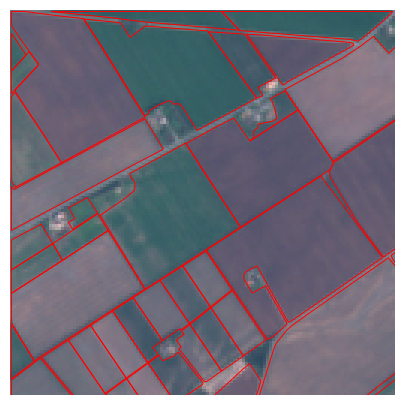

COCO_val2016_000000100006.jpg


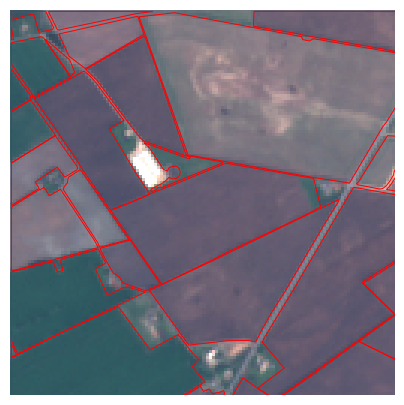

In [11]:
utils.coco.plot_coco(inpath_json=outpath / r'annotations\val2016.json', 
                     inpath_image_folder=outpath / r'images\val2016', 
                     end=2)